In [142]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qMaxValueEntropy
from botorch.optim.optimize import optimize_acqf

from botorch.acquisition.analytic import ExpectedImprovement
from utils import pick_acqf, pick_kernel, pick_test_function, set_matplotlib_params


torch.set_default_dtype(torch.double)
set_matplotlib_params()

In [143]:
exp, ker, acqf, n_init, seed = "Zhou", "RBF", "MES", 20,24
budget = 100
torch.manual_seed(seed)

problem = pick_test_function(exp)
bounds = torch.tensor(problem._bounds).T
dim = bounds.shape[1]
sigma = .2 # hardcoded noise level, but should be function-dependent.

data = {}
data["train_X"] = (bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n_init, dim))
train_Y = - problem(data["train_X"]).view(-1, 1)
data["train_Y"] = train_Y + sigma * torch.randn(size=train_Y.shape)

### for plotting of unknown function
X = torch.linspace(float(bounds[0]), float(bounds[1]), 101).reshape(-1, 1)
Y = - problem(X)

In [156]:
K = pick_kernel(ker, dim)
gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=K)
mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
fit_gpytorch_model(mll, max_retries=10);

In [157]:
-mll(gpr(data["train_X"]), data["train_Y"]).sum()

tensor(203.4649, grad_fn=<NegBackward0>)

In [149]:
gpr_post_mean = gpr.likelihood(gpr(X)).mean.detach().numpy()
gpr_post_var = np.sqrt(gpr.likelihood(gpr(X)).variance.detach().numpy())

In [150]:
print(gpr.covar_module.outputscale.item(), gpr.covar_module.base_kernel.lengthscale.item(), gpr.likelihood.noise.item()) # GP hyperparameters post optimization

0.7131519664454926 0.09999313323870145 0.022514588682480154


In [151]:
# bounds = problem._bounds
candidate_set = torch.rand(100, bounds.size(1), device=bounds.device, dtype=bounds.dtype)
candidate_set = bounds[0] + (bounds[1] - bounds[0]) * candidate_set

qMES = qMaxValueEntropy(gpr, candidate_set)
#UCB = UpperConfidenceBound(gpr, beta=.2)
EI = ExpectedImprovement(gpr, data["train_Y"].max())

In [152]:
mes_eval = qMES(X[:, None, :]).detach().numpy()
#ucb_eval = UCB(X[:, None, :]).detach().numpy()
ei_eval = EI(X[:, None, :]).detach().numpy()

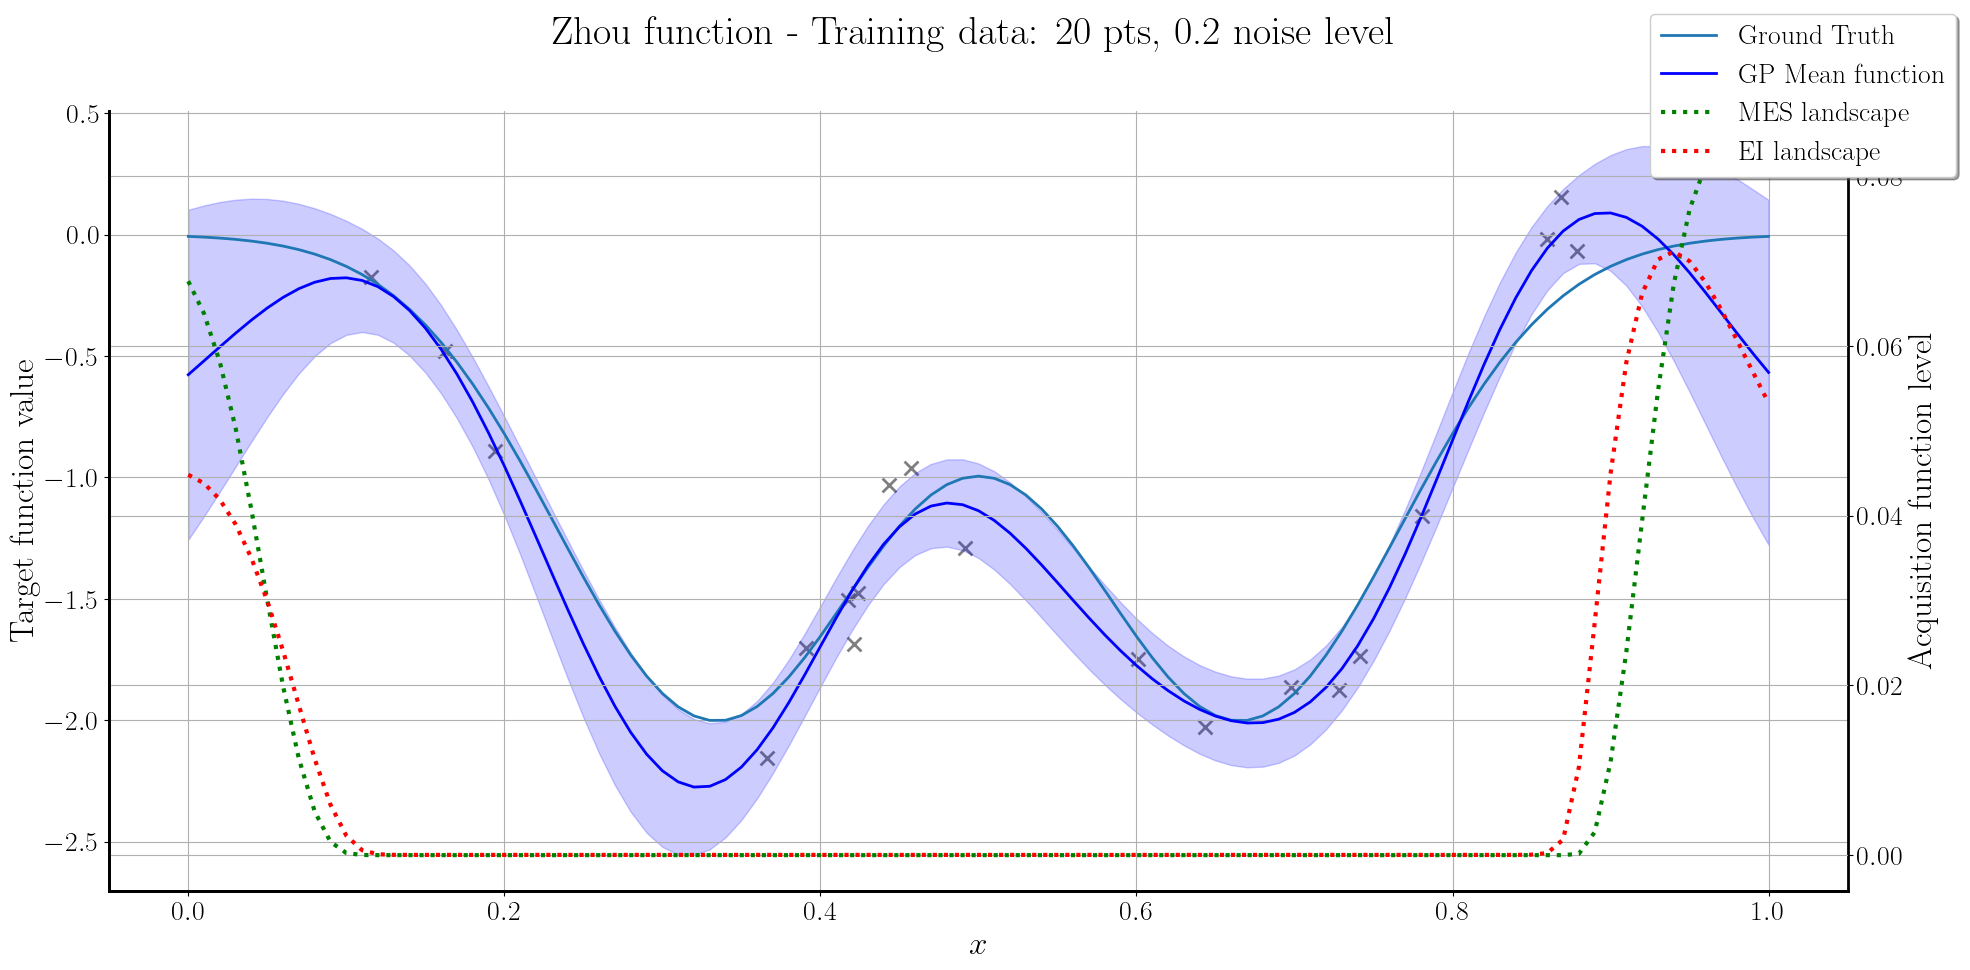

In [153]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes.plot(X, Y, label='Ground Truth')
axes.scatter(data["train_X"], data["train_Y"], alpha=.5, color='black', marker='x', s=100)
axes.plot(X, gpr_post_mean, 'b', label='GP Mean function')
axes.fill_between(X.squeeze(), gpr_post_mean - gpr_post_var,
                     gpr_post_mean + gpr_post_var, alpha=0.2, color='b')
ax2 = axes.twinx()
ax2.plot(X, mes_eval, linestyle='dotted', color='green', linewidth=3, label='MES landscape')
#ax2.plot(X, ucb_eval, linestyle='dotted', color='purple', linewidth=3, label='UCB landscape')
ax2.plot(X, ei_eval, linestyle='dotted', color='red', linewidth=3, label='EI landscape')

ax2.set_ylabel("Acquisition function level")
axes.set_ylabel('Target function value')
axes.set_xlabel('$x$')
axes.spines['right'].set_visible(True)
fig.suptitle(f"Zhou function - Training data: {n_init} pts, {sigma} noise level")
fig.legend(shadow=True)
fig.tight_layout()
plt.show()

In [108]:
import math

from torch import Tensor

from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from typing import Optional, Union
from botorch.models.model import Model
from botorch.acquisition.objective import PosteriorTransform
from botorch.utils.transforms import t_batch_mode_transform


class CustomUpperConfidenceBound(AnalyticAcquisitionFunction):
    r"""Single-outcome Upper Confidence Bound (UCB).

    Analytic upper confidence bound that comprises of the posterior mean plus an
    additional term: the posterior standard deviation weighted by a trade-off
    parameter, `beta`. Only supports the case of `q=1` (i.e. greedy, non-batch
    selection of design points). The model must be single-outcome.

    `UCB(x) = mu(x) + sqrt(beta) * sigma(x)`, where `mu` and `sigma` are the
    posterior mean and standard deviation, respectively.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> UCB = UpperConfidenceBound(model, beta=0.2)
        >>> ucb = UCB(test_X)
    """

    def __init__(
        self,
        model: Model,
        beta: Union[float, Tensor],
        lcb=False,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ) -> None:
        r"""Single-outcome Upper Confidence Bound.

        Args:
            model: A fitted single-outcome GP model (must be in batch mode if
                candidate sets X will be)
            beta: Either a scalar or a one-dim tensor with `b` elements (batch mode)
                representing the trade-off parameter between mean and covariance
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
        """
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("beta", torch.as_tensor(beta))
        self.lcb = lcb
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate the Upper Confidence Bound on the candidate set X.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Upper Confidence Bound values at the
            given design points `X`.
        """
        mean, sigma = self._mean_and_sigma(X)
        factor = self.beta.sqrt() if not self.lcb else - self.beta.sqrt()
        return (mean if self.maximize else -mean) + factor * sigma


def compute_stopping_criterion(model, previousmodel, data):

    argmax, argoldmax = (data['train_Y']).argmin(), (data['train_Y'][:-1]).argmin()
    curr_max = data['train_X'][argmax].view(1,1)
    old_max = data['train_X'][argoldmax].view(1,1)

    modeleval, previousmodeleval = model(curr_max), previousmodel(old_max)
    covar = model(torch.cat((curr_max, old_max))).covariance_matrix[0][1]
    deltamu = (previousmodeleval.mean) - (modeleval.mean)
 
    clip = 1e-16 # avoid taking square root of negative...
    clipsqrt = max(modeleval.variance + previousmodeleval.variance - 2 * covar, clip)
    v = math.sqrt(clipsqrt)
    g = - deltamu / v
    
    dist = torch.distributions.normal.Normal(0, 1)
    phig = torch.exp(dist.log_prob(g))
    Phig = dist.cdf(g)
    
    previousmodelcurreval = previousmodel(data["train_X"][-1])
    mean, variance = previousmodelcurreval.mean, previousmodelcurreval.variance
    noise = model.likelihood.noise.item()
    noiseinv = noise**(-1)
    lambdainv = noise
    lamb = noiseinv
    firstkl = torch.log(1 + lamb * variance)
    secondkl = variance / (variance + lambdainv)
    thirdkl = (variance * (data["train_Y"][-1] - mean)**2) / (variance + lambdainv)**2
    kl = .5 * max((firstkl - secondkl + thirdkl),clip)
    beta = .2

    UCB = CustomUpperConfidenceBound(model, beta)
    LCB = CustomUpperConfidenceBound(model, beta, lcb=True, maximize=False)

    _, val= optimize_acqf(
                    acq_function=LCB, 
                    bounds=bounds,
                    q=1, # batch size, i.e. we only query one point
                    num_restarts=10,
                    raw_samples=512,
                )

    kappa = UCB(data["train_X"][:-1].unsqueeze(-1)).min() - (-val)

    deltart = torch.abs(deltamu) + v * (phig + g * Phig) + kappa * math.sqrt(1/2 * kl)


    ### COMPUTE st
    delta = .05 # w/ prob 1-delta 
    c = math.sqrt(- 2 * math.log(delta))
    previousmodelargmaxvar = previousmodel(curr_max).variance
    numst = (torch.sqrt(previousmodelargmaxvar) + kappa / 2) * torch.sqrt(variance) * c
    denomst = math.sqrt(lamb) * (variance + lambdainv)
    st = numst / denomst
    if deltart < st:
        status = False
    else:
        status = True
    return status, deltart, st, kappa

In [109]:
##### BO LOOP
import warnings
warnings.filterwarnings("ignore")


data["regrets"] = torch.zeros(budget + 2)
data["regrets"][0] = problem.optimal_value - data["train_X"].max()
status = True
b = 1
cc = []
while status and b < 80:
    # af = CustomUpperConfidenceBound(gpr, 0.2 * math.log(1 + 0.2*b), lcb=True)
    af = CustomUpperConfidenceBound(gpr, 0.2, maximize=False, lcb=True)
    #af = CustomUpperConfidenceBound(gpr, 0.2)
   # af = pick_acqf(acqf, data, gpr, bounds)
    candidates, _ = optimize_acqf(
                            acq_function=af, 
                            bounds=bounds,
                            q=1, # batch size, i.e. we only query one point
                            num_restarts=10,
                            raw_samples=512,
                            )
    y = - problem(candidates)
    data["train_X"] = torch.cat((data["train_X"], candidates))
    data["train_Y"] = torch.cat((data["train_Y"], y.view(-1, 1)))
    data["regrets"][b + 1] = problem.optimal_value - data["train_Y"].max()
    b += 1
    previousmodel = copy.deepcopy(gpr)
    K = pick_kernel(ker, dim)                         
    gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=K)
    mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
    fit_gpytorch_model(mll, max_retries=10);
    status, deltart, st, kappa = compute_stopping_criterion(gpr, previousmodel, data)
    # print(status, deltart.detach(), st.detach(), kappa.detach())
    #cc.append(float(deltart))
    #if deltart < 0.1 * np.median(cc[:20]) and len(cc) >= 20:
    #    status = False
    print(deltart, st)

tensor([0.6793], grad_fn=<AddBackward0>) tensor([1.3145e-05], grad_fn=<DivBackward0>)
tensor([0.0965], grad_fn=<AddBackward0>) tensor([0.2029], grad_fn=<DivBackward0>)


In [110]:
K = pick_kernel(ker, dim)
gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=K)
mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
fit_gpytorch_model(mll, max_retries=100);

gpr_post_mean = gpr(X).mean.detach().numpy()
gpr_post_var = np.sqrt(gpr.likelihood(gpr(X)).variance.detach().numpy())

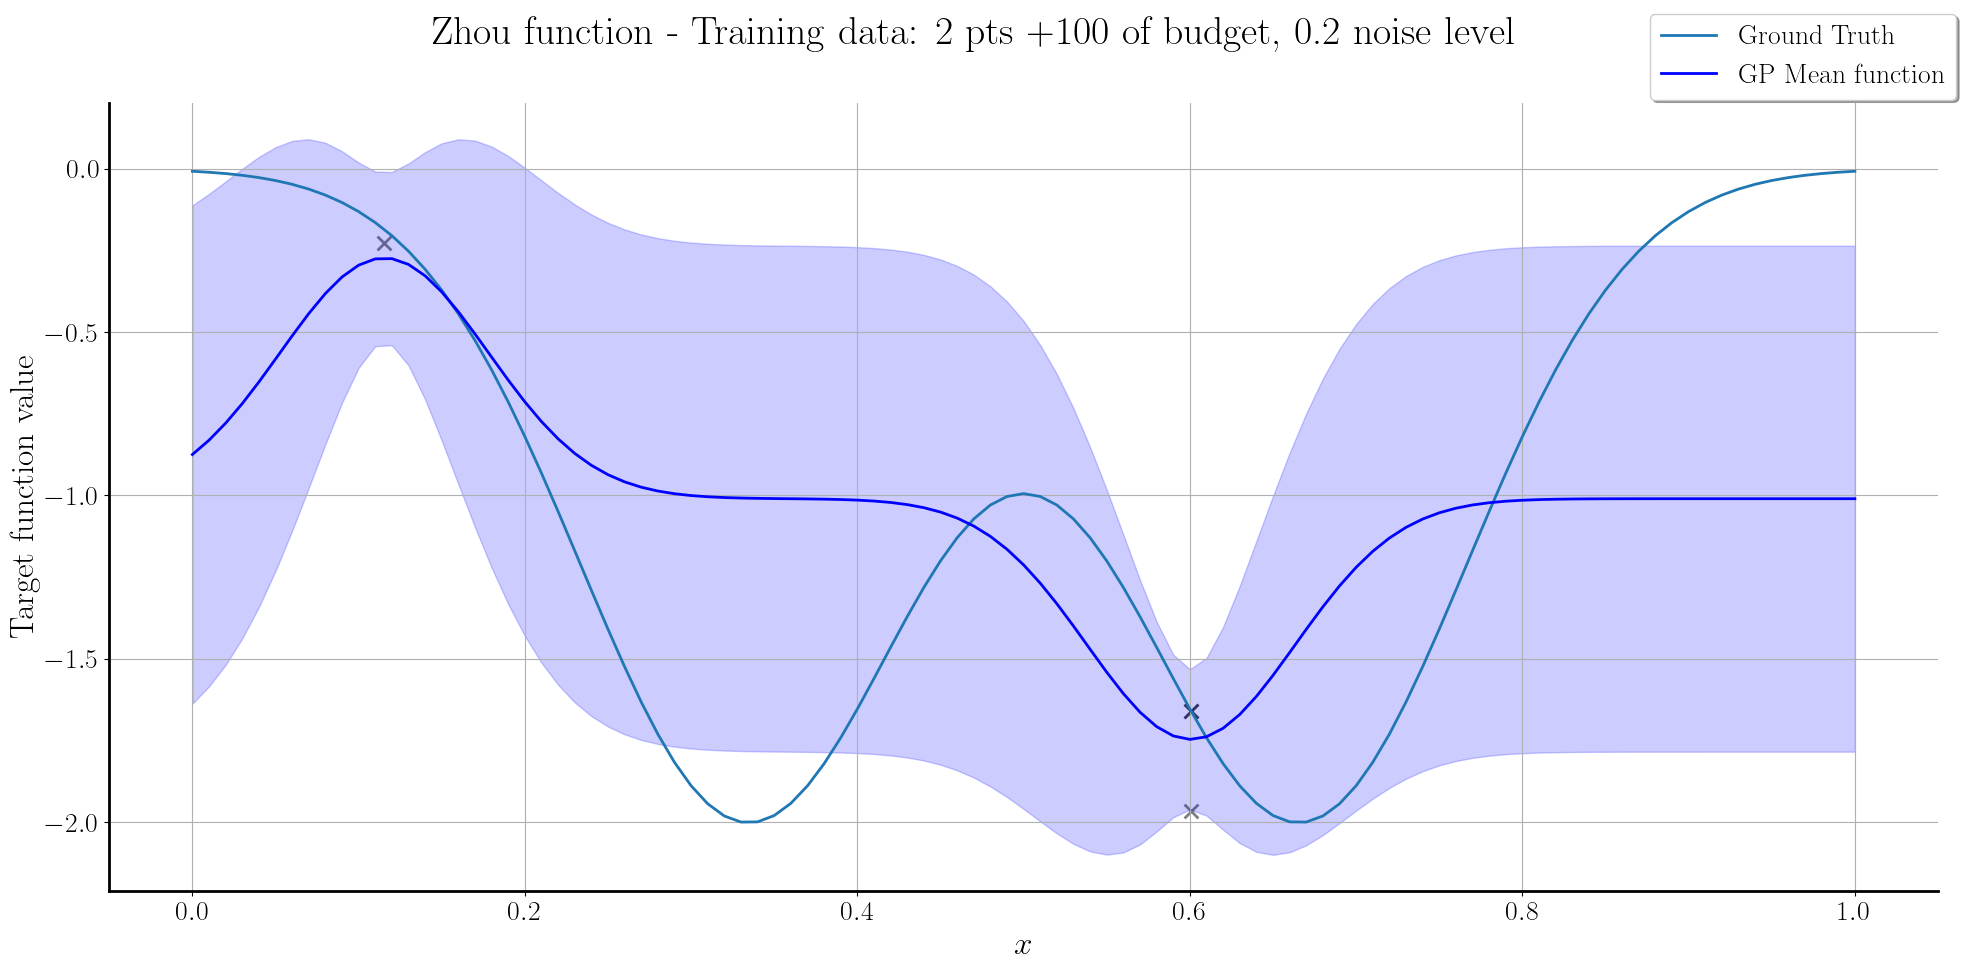

In [111]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes.plot(X, Y, label='Ground Truth')
axes.scatter(data["train_X"], data["train_Y"], alpha=.5, color='black', marker='x', s=100)
axes.plot(X, gpr_post_mean, 'b', label='GP Mean function')
axes.fill_between(X.squeeze(), gpr_post_mean - gpr_post_var,
                     gpr_post_mean + gpr_post_var, alpha=0.2, color='b')
axes.set_ylabel('Target function value')
axes.set_xlabel('$x$')
fig.suptitle(f"Zhou function - Training data: {n_init} pts +{budget} of budget, {sigma} noise level")
fig.legend(shadow=True)
fig.tight_layout()
plt.show()

In [81]:
gpr.likelihood.noise

Parameter containing:
tensor([1.0000e-04], requires_grad=True)